Loaded Universe: <XYZReader ../Inputs/prod/kalj_T0.5_n360_v300_prod_10000000_1.unwrap.xyz with 501 frames of 360 atoms>


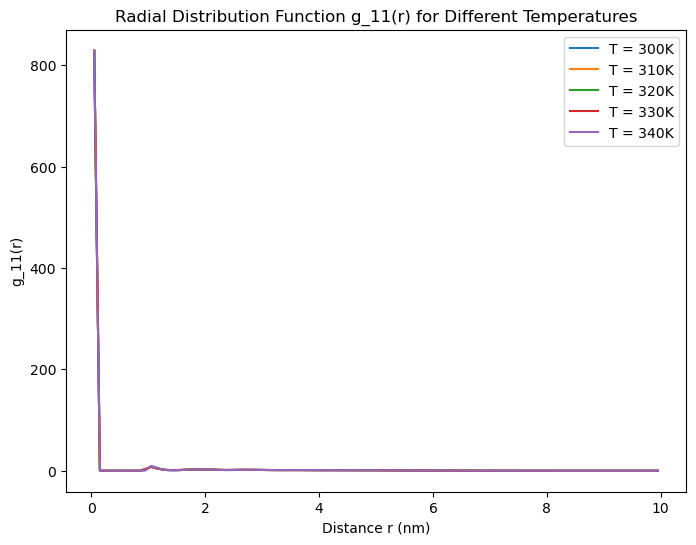

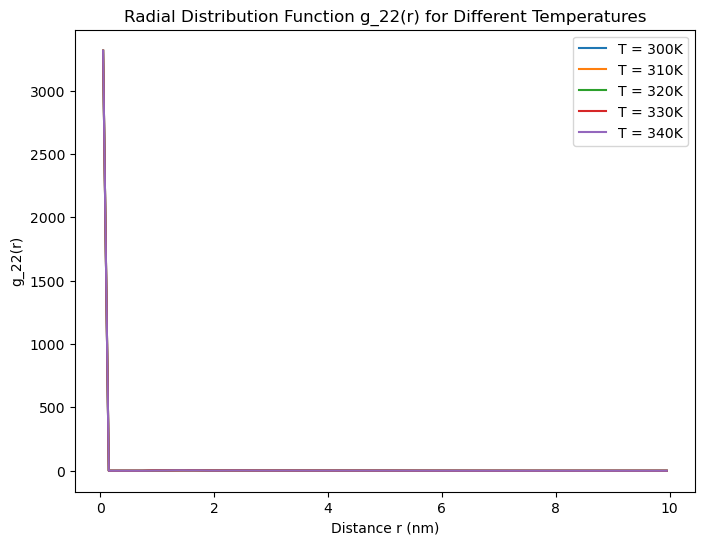

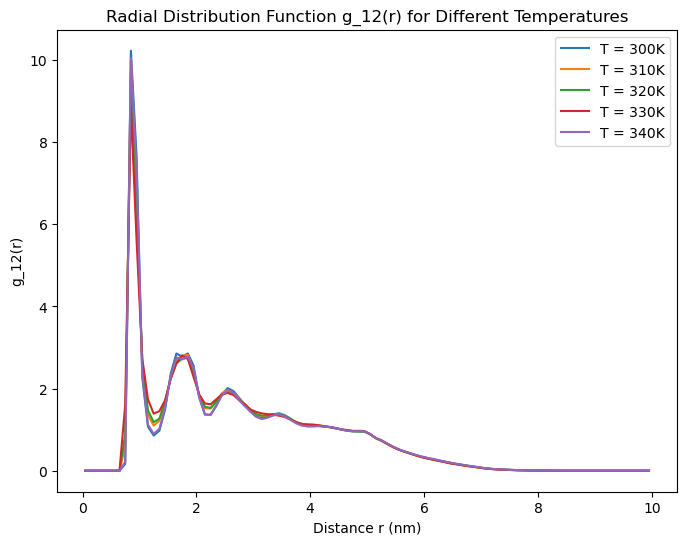

In [18]:
import MDAnalysis as mda
import glob
import matplotlib.pyplot as plt
from MDAnalysis.analysis import rdf

# Define the directory containing trajectory and topology files
trajectory_files = glob.glob("../Inputs/prod/*kalj*.xyz")
topology_file = glob.glob("../Inputs/equil/*kalj*.lammpstrj")[0]

try:
    # Initialize Universe with topology format specified
    u = mda.Universe(topology_file, trajectory_files[0], topology_format="LAMMPSDUMP")
    print("Loaded Universe:", u.trajectory)
except Exception as e:
    print("Error loading Universe:", e)
    
# Assign masses if needed, using atom types
mass_dict = {1: 39.95, 2: 40.08}  # Customize these values
for atom in u.atoms:
    atom.mass = mass_dict.get(atom.type, 1.0)  # Default to 1.0 if type not in dict

# Set up RDF analysis for each temperature
rdf_data = {'11': [], '22': [], '12': []}
r_values = None
selections = {"type1": "type 1", "type2": "type 2"}  # Updated to use type

for temp, traj_file in zip([300, 310, 320, 330, 340], trajectory_files):
    universe = mda.Universe(topology_file, traj_file, topology_format="LAMMPSDUMP")
    
    # Manually set the box dimensions, e.g., if cubic with 10.0 nm per side
    universe.dimensions = [10.0, 10.0, 10.0, 90.0, 90.0, 90.0]  # Update as per your box dimensions
    
    group1 = universe.select_atoms(selections["type1"])
    group2 = universe.select_atoms(selections["type2"])

    rdf_11 = rdf.InterRDF(group1, group1, nbins=100, range=(0.0, 10.0))
    rdf_22 = rdf.InterRDF(group2, group2, nbins=100, range=(0.0, 10.0))
    rdf_12 = rdf.InterRDF(group1, group2, nbins=100, range=(0.0, 10.0))

    rdf_11.run()
    rdf_22.run()
    rdf_12.run()

    if r_values is None:
        r_values = rdf_11.results.bins

    rdf_data['11'].append((temp, rdf_11.results.rdf))
    rdf_data['22'].append((temp, rdf_22.results.rdf))
    rdf_data['12'].append((temp, rdf_12.results.rdf))

def plot_rdf(r_values, rdf_data, pair_type):
    plt.figure(figsize=(8, 6))
    for temp, rdf_values in rdf_data[pair_type]:
        plt.plot(r_values, rdf_values, label=f"T = {temp}K")
    plt.xlabel("Distance r (nm)")
    plt.ylabel(f"g_{pair_type}(r)")
    plt.legend()
    plt.title(f"Radial Distribution Function g_{pair_type}(r) for Different Temperatures")
    plt.show()

# Plot RDFs for each pair type at different temperatures
plot_rdf(r_values, rdf_data, '11')
plot_rdf(r_values, rdf_data, '22')
plot_rdf(r_values, rdf_data, '12')
